In [1]:
from tank_kills_v3 import TankKills
import random
from pynput.keyboard import Controller,Key
import time
import pygame
import matplotlib.pyplot as plt
import numpy as np
import json
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/q_table_tank_kills')


pygame 2.2.0 (SDL 2.0.22, Python 3.10.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


2023-03-06 11:03:04.292588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 11:03:06.546573: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-06 11:03:06.546722: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-06 11:03:06.546736: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
all_actions = ["up","right","down","left"]

### Loading Q_table

In [3]:
with open('q_table.json','r') as f:
    data = json.load(f)
q_table = np.array(data['q_table'])

### Function to save Q_table

In [4]:
def save_q_tabel():
    data = {}
    data['q_table'] = q_table.tolist()
    with open('q_table.json','w') as f:
        json.dump(data,f)

In [4]:
# state-action values for spawn point
q_table[300*400]

array([-52.15491193, -54.49909468, -50.39114529, -50.29053577])

### Parameters

In [6]:
num_episodes = 3000
# max_steps_per_episode = 5
learning_rate = 0.1 # alpha
discount_factor = 0.90 # gamma

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.007

### Training loop

In [7]:
rewards_all_episodes = []
all_actions_taken = []
no_of_actions_each_episode = []

for episode in range(num_episodes):
    print(f"-------Game: {episode+1}/{num_episodes}-------")

    # Creating new game enviroment with screen res. of 600 x600
    # Initializing variables
    env = TankKills(600,600)
    running = True
    reward_current_episode = 0

    # Starting state is spawn co-ordinates(x,y) of player
    state = 300*400
    reward = 0
    action_taken_in_episode = 0
    actions_taken_in_episode  = []

    while running:

        # Setting Reward to zero
        reward = 0
        # Exploration rate threshold from random uni. Distribution
        exploration_rate_threshold = random.uniform(0,1)
        # E-greedy for exploration vs exploitation
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[state,:])
        else:
            action = random.randint(0,3)
        
        # Taking action from using either q_table or e-greedy policy
        # pp is player position cordinates
        # ep is enemy position cordinates
        running,reward,score,pp,ep = env.play(action=all_actions[action])

        # New state is product of x and y co-ordinate of player_position
        new_state = int(pp[0])*int(pp[1])

        # Bellman's Equation for updating Q values
        q_table[state,action] = q_table[state,action] * (1-learning_rate) + learning_rate*(reward+discount_factor*np.max(q_table[new_state,:]))
        # Transition to new state
        state = new_state

        # Keeping track of rewards and actions taken
        all_actions_taken.append(action)
        actions_taken_in_episode.append(action)
        action_taken_in_episode += 1
        reward_current_episode += reward

        # Breaking if game is completed
        if not running:
            pygame.display.quit()
            break
        
        # Decaying Exploration rate
        exploration_rate = min_exploration_rate+(max_exploration_rate-min_exploration_rate)*np.exp(-exploration_decay_rate*episode)
    
    # Tensorboard stuff
    writer.add_scalar('Score',score,episode)
    writer.add_scalar('Rewards',reward_current_episode,episode)
    writer.add_scalar('No. of actions',action_taken_in_episode,episode)
    writer.add_histogram('Actions Taken',np.array(actions_taken_in_episode))
    writer.close()

    # Keeping Track of rewards nad actions
    rewards_all_episodes.append(reward_current_episode)
    no_of_actions_each_episode.append(action_taken_in_episode)
    print(f"-- Score: {score}")
    print(f"-- Total Actions Taken: {action_taken_in_episode}")
    pygame.display.quit()

    # Saving Q_table after Each episode
    save_q_tabel()

-------Game: 1/3000-------
-- Score: 0
-- Total Actions Taken: 2046
-------Game: 2/3000-------
-- Score: 2
-- Total Actions Taken: 3371
-------Game: 3/3000-------
-- Score: 0
-- Total Actions Taken: 2026
-------Game: 4/3000-------
-- Score: 0
-- Total Actions Taken: 2096
-------Game: 5/3000-------
-- Score: 1
-- Total Actions Taken: 3633
-------Game: 6/3000-------
-- Score: 2
-- Total Actions Taken: 4262
-------Game: 7/3000-------
-- Score: 1
-- Total Actions Taken: 2635
-------Game: 8/3000-------
-- Score: 1
-- Total Actions Taken: 2668
-------Game: 9/3000-------
-- Score: 1
-- Total Actions Taken: 2668
-------Game: 10/3000-------
-- Score: 0
-- Total Actions Taken: 2016
-------Game: 11/3000-------
-- Score: 1
-- Total Actions Taken: 2406
-------Game: 12/3000-------
-- Score: 1
-- Total Actions Taken: 2557
-------Game: 13/3000-------
-- Score: 0
-- Total Actions Taken: 2076
-------Game: 14/3000-------
-- Score: 0
-- Total Actions Taken: 2086
-------Game: 15/3000-------
-- Score: 1
-- 

In [8]:
pygame.display.quit()

### Q Table values of spawn location

In [9]:
print(q_table[300*400])

[-52.15491193 -54.49909468 -50.39114529 -50.29053577]


### Rewards per game

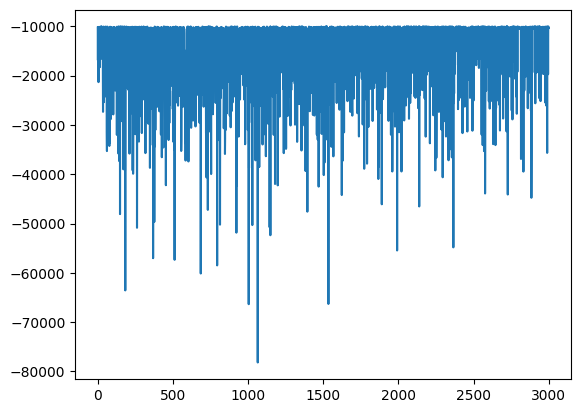

In [10]:
plt.plot(rewards_all_episodes)
plt.show()

### Number of actions each game

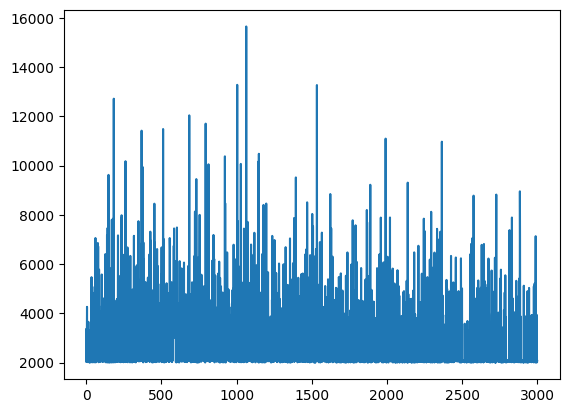

In [11]:
plt.plot(no_of_actions_each_episode)
plt.show()

### Distribution of all actions

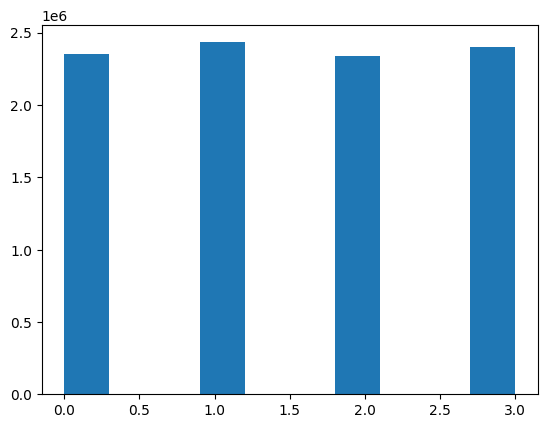

In [12]:
plt.hist(all_actions_taken)
plt.show()